# Imports

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
import seaborn as sns

sns.set_theme()

# Load Data and Preprocessing

In [16]:
from loadAndPreprocess import load_and_preprocess

'''
well_info: Well, X, Y, Total Resources
sensor_data: Depth, Porosity, Hydrate Saturation, Estimated Resources
'''
well_info, sensor_data_list = load_and_preprocess()


# Get the Statistical Distribution

In [17]:
def drop_outliers(data: np.ndarray, threshold=3):
    z = np.abs((data - data.mean()) / data.std())
    return data[z < threshold]

In [18]:
def fit_norm_and_plot(data: np.ndarray, name: str):
    from scipy.stats import norm
    mu, std = norm.fit(data)

    # Plot the distribution of the hydrate saturation
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=40, density=True, alpha=0.7)

    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=1)

    plt.title(f'{name} Distribution (Fit to Normal Distribution)')
    plt.xlabel(name)
    plt.ylabel('Probability Density')
    plt.grid(True)
    plt.show()
    
    return mu, std

In [19]:
def fit_gmm_and_plot(data: np.ndarray, name: str, n_components: int = 3) -> object:
    from sklearn.mixture import GaussianMixture
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(data.reshape(-1, 1))

    # Plot the distribution
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=40, density=True, alpha=0.7, label='Data histogram')

    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 1000).reshape(-1, 1)
    logprob = gmm.score_samples(x)
    responsibilities = np.exp(logprob)

    plt.plot(x, responsibilities, 'k', linewidth=1, label='GMM fit')

    plt.title(f'{name} Distribution (Fit to Gaussian Mixture Model)')
    plt.xlabel(name)
    plt.ylabel('Probability Density')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return gmm

### Distribution of Hydrate Saturation

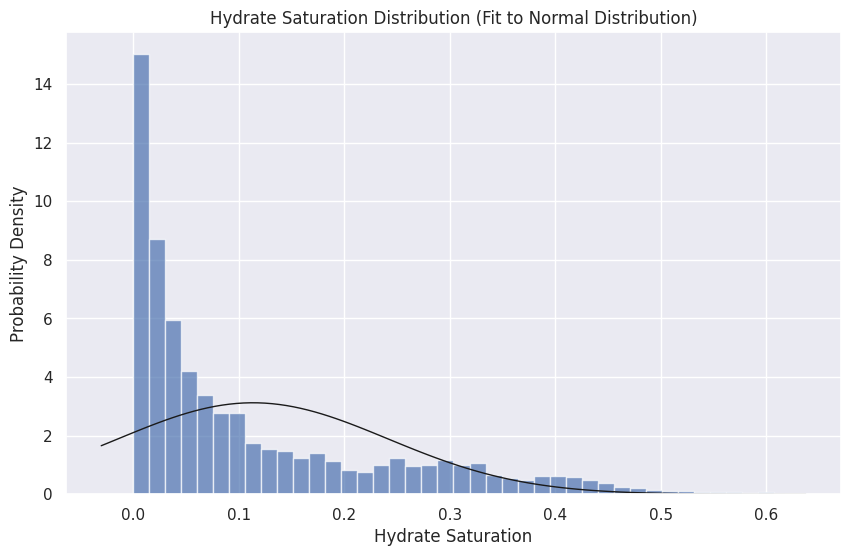

(0.11351333316926242, 0.1277538582510373)

In [20]:
# Get the distibution of the hydrate saturation
hydrate_saturation = []
for sensor_data in sensor_data_list:
    hydrate_saturation.extend(sensor_data['Hydrate Saturation'].dropna())

hydrate_saturation = np.array(hydrate_saturation)


fit_norm_and_plot(drop_outliers(hydrate_saturation[hydrate_saturation != 0]), 'Hydrate Saturation')

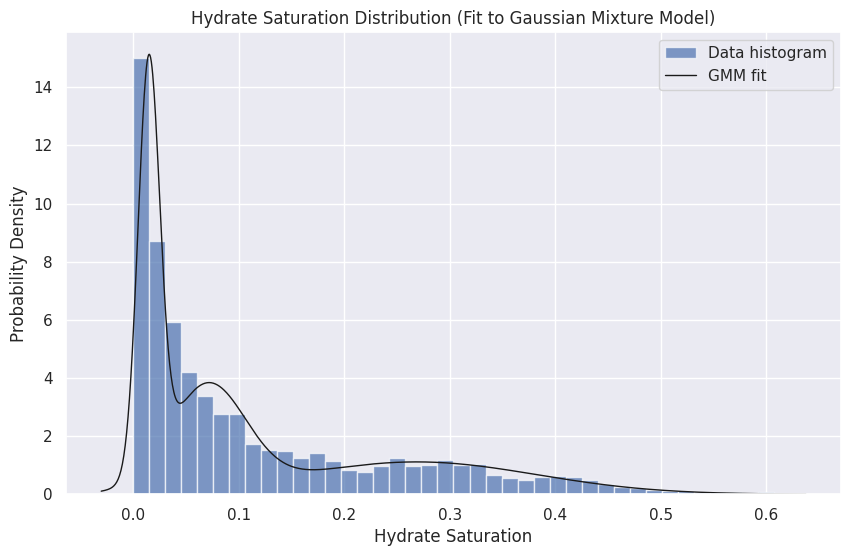

GaussianMixture(n_components=3, random_state=0)

In [21]:
fit_gmm_and_plot(drop_outliers(hydrate_saturation[hydrate_saturation != 0]), 'Hydrate Saturation', 3)

### Distribution of Porosity

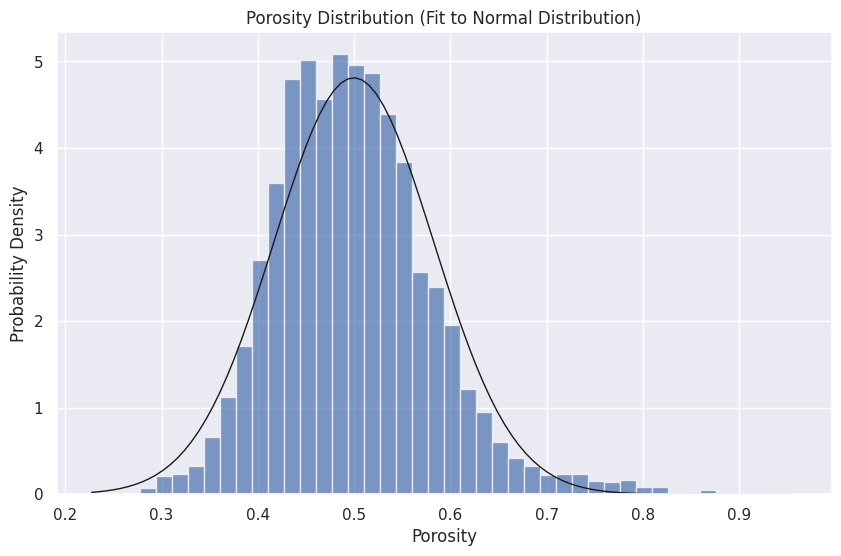

(0.49971813555638256, 0.0829126678872652)

In [22]:
# Get the distibution of the porosity
porosity = []
for sensor_data in sensor_data_list:
    porosity.extend(sensor_data['Porosity'].dropna())

porosity = np.array(porosity)

fit_norm_and_plot(porosity, "Porosity")

### Distribution of Valid Thickness

> Valid thickness is the thickness of the an continual layer contains resources


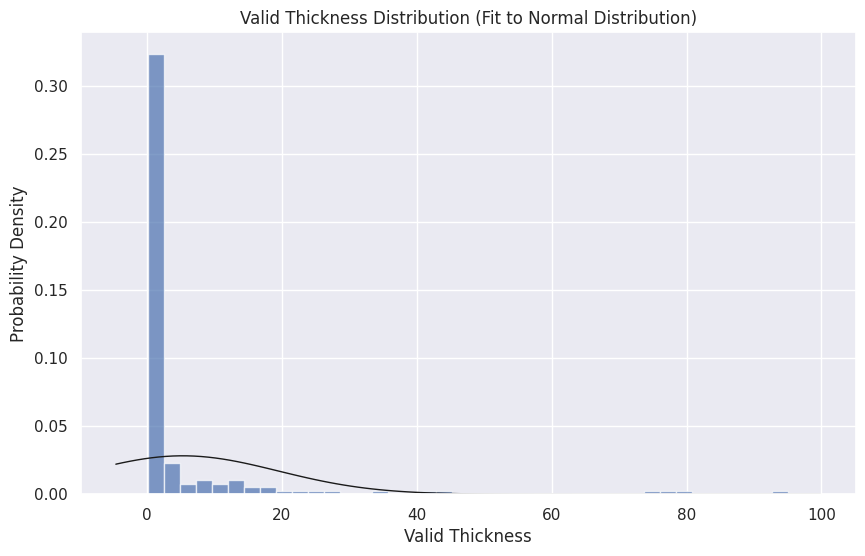

(5.313300613496928, 14.130376163965092)

In [23]:
# Calculate the valid thickness in each well.
valid_thickness = []
for sensor_data in sensor_data_list:
    sensor_data.dropna(inplace=True)
    flag = False
    for i in range(len(sensor_data)):
        if sensor_data.iloc[i]['Estimated Resources'] != 0 and flag == False:
            current_start = sensor_data.iloc[i]['Depth']
            flag = True
        if sensor_data.iloc[i]['Estimated Resources'] == 0 and flag == True:
            current_end = sensor_data.iloc[i]['Depth']
            valid_thickness.append(current_end - current_start)
            flag = False

valid_thickness = np.array(valid_thickness)
fit_norm_and_plot(valid_thickness, "Valid Thickness")

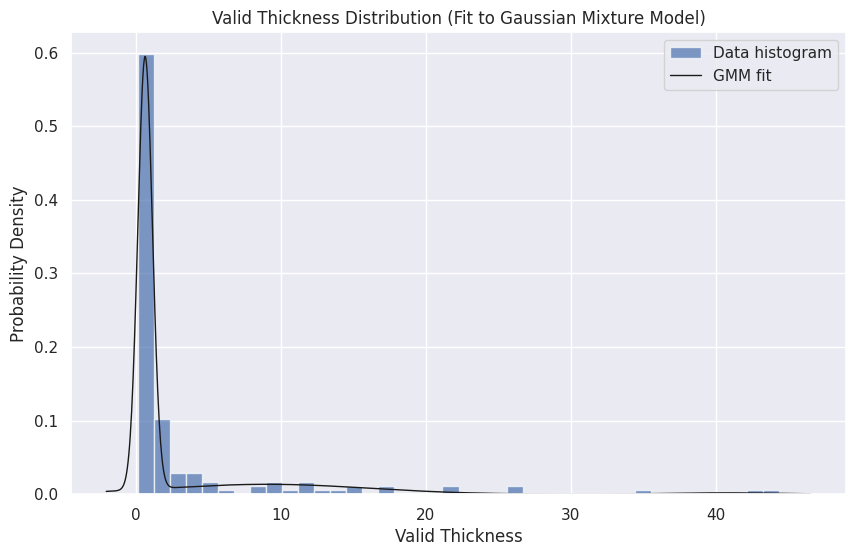

GaussianMixture(n_components=3, random_state=0)

In [24]:
fit_gmm_and_plot(drop_outliers(valid_thickness, 3), "Valid Thickness")

In [25]:
# Calculate the valid thickness in each well.
v_thick_list = []
for sensor_data in sensor_data_list:
    cur_v_thick = 0
    sensor_data.dropna(inplace=True)
    flag = False
    for i in range(len(sensor_data)):
        if sensor_data.iloc[i]['Estimated Resources'] != 0 and flag == False:
            current_start = sensor_data.iloc[i]['Depth']
            flag = True
        if sensor_data.iloc[i]['Estimated Resources'] == 0 and flag == True:
            current_end = sensor_data.iloc[i]['Depth']
            cur_v_thick += (current_end - current_start)
            flag = False
            
    v_thick_list.append(cur_v_thick)

well_info["Valid Thickness"] = v_thick_list

In [26]:
# Plot the Contour of the valid thickness
fig = go.Figure(data=[go.Contour(z=well_info["Valid Thickness"], x=well_info['X'], y=well_info['Y'], colorscale='Viridis')])
fig.update_layout(
    height=600,
    width=700,
    title_text='Contour of Valid Thickness'
)

fig.show()

In [27]:
# Plot the Contour of the valid thickness
fig = go.Figure(data=[go.Contour(z=well_info['Total Resources'], x=well_info['X'], y=well_info['Y'], colorscale='Viridis')])
fig.update_layout(
    height=600,
    width=700,
    title_text='Total Resources'
)

fig.show()